In [19]:
from utils import *
import shutil
import os

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

import numpy as np
import torch
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    torch.cuda.set_device(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BASE_PATH = "./data"

In [56]:
def load_data(base_path="./data"):
    """ Load the data in PyTorch Tensor.

    :return: (zero_train_matrix, train_data, valid_data, test_data)
        WHERE:
        zero_train_matrix: 2D sparse matrix where missing entries are
        filled with 0.
        train_data: 2D sparse matrix
        valid_data: A dictionary {user_id: list,
        user_id: list, is_correct: list}
        test_data: A dictionary {user_id: list,
        user_id: list, is_correct: list}
    """
    train_matrix = load_train_sparse(base_path).toarray()
    valid_data = load_valid_csv(base_path)
    test_data = load_public_test_csv(base_path)

    zero_train_matrix = train_matrix.copy()
    # Fill in the missing entries to 0.
    zero_train_matrix[np.isnan(train_matrix)] = 0
    # Change to Float Tensor for PyTorch.
    zero_train_matrix = torch.FloatTensor(zero_train_matrix)
    train_matrix = torch.FloatTensor(train_matrix)

    return zero_train_matrix, train_matrix, valid_data, test_data


class AutoEncoder(nn.Module):
    def __init__(self, num_question, k=100):
        """ Initialize a class AutoEncoder.

        :param num_question: int
        :param k: int
        """
        super(AutoEncoder, self).__init__()

        # Define linear functions.
        self.g = nn.Linear(num_question, k)
        self.h = nn.Linear(k, num_question)

    def get_weight_norm(self):
        """ Return ||W^1||^2 + ||W^2||^2.

        :return: float
        """
        g_w_norm = torch.norm(self.g.weight, 2) ** 2
        h_w_norm = torch.norm(self.h.weight, 2) ** 2
        return g_w_norm + h_w_norm

    def forward(self, inputs):
        """ Return a forward pass given inputs.

        :param inputs: user vector.
        :return: user vector.
        """
        #####################################################################
        # TODO:                                                             #
        # Implement the function as described in the docstring.             #
        # Use sigmoid activations for f and g.                              #
        #####################################################################
        out = torch.sigmoid(self.g(inputs))
        out = torch.sigmoid(self.h(out))
        #####################################################################
        #                       END OF YOUR CODE                            #
        #####################################################################
        return out


def train(model, lr, lamb, train_data, zero_train_data, valid_data, num_epoch):
    """ Train the neural network, where the objective also includes
    a regularizer.

    :param model: Module
    :param lr: float
    :param lamb: float
    :param train_data: 2D FloatTensor
    :param zero_train_data: 2D FloatTensor
    :param valid_data: Dict
    :param num_epoch: int
    :return: None
    """

    # Create checkpoints folder
    if os.path.isdir('./checkpoints'):
        shutil.rmtree('./checkpoints')
    os.mkdir('./checkpoints')
    
    # Tell PyTorch you are training the model.
    model.train()

    # Define optimizers and loss function.
    optimizer = optim.SGD(model.parameters(), lr=lr)
    num_student = train_data.shape[0]

    # For plotting
    train_losses = []
    valid_losses = []
    valid_accuracies = []
    epochs = []
    
    # For early stop
    best_valid_acc = 0

    for epoch in range(0, num_epoch):
        train_loss = 0.

        for user_id in range(num_student):
            inputs = Variable(zero_train_data[user_id]).unsqueeze(0).to(device)
            target = inputs.clone().to(device)

            optimizer.zero_grad()
            output = model(inputs)

            # Mask the target to only compute the gradient of valid entries.
            nan_mask = np.isnan(train_data[user_id].unsqueeze(0).numpy())
            target[0][nan_mask] = output[0][nan_mask]

            loss = torch.sum((output - target) ** 2.) + lamb/2*model.get_weight_norm()
            loss.backward()

            train_loss += loss.item()
            optimizer.step()
            
        [valid_loss, valid_acc] = evaluate(model, zero_train_data, valid_data)
        
        print("Epoch: {} \tTraining Cost: {:.6f} \tValid Acc: {}".format(epoch, train_loss, valid_acc))
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)
        epochs.append(epoch)
        
        # Save best model
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            torch.save(model.state_dict(), f'./checkpoints/epoch_{epoch}.pt')
    
    
    # Plot training curve
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)

    ax1.plot(epochs, train_losses)
    ax1.set_title("Training Loss Curve")
    ax1.set(ylabel='Loss')

    ax2.plot(epochs, valid_accuracies)
    ax2.set_title("Validation Accuracy Curve")
    ax2.set(xlabel='Epochs', ylabel='Accuracy')

    plt.subplots_adjust(hspace=0.5)
    plt.show()
    
    """
    plt.plot(epochs, train_losses, label="Train")
    plt.plot(epochs, valid_losses, label="valid")
    plt.legend(loc="best")
    plt.show()
    """
    
    
def evaluate(model, train_data, valid_data):
    """ Evaluate the valid_data on the current model.

    :param model: Module
    :param train_data: 2D FloatTensor
    :param valid_data: A dictionary {user_id: list,
    question_id: list, is_correct: list}
    :return: float
    """
    # Tell PyTorch you are evaluating the model.
    model.eval()

    total = 0
    correct = 0
    loss = 0

    for i, u in enumerate(valid_data["user_id"]):
        inputs = Variable(train_data[u]).unsqueeze(0).to(device)
        output = model(inputs)
        
        # Accuracy
        guess = output[0][valid_data["question_id"][i]].item() >= 0.5
        if guess == valid_data["is_correct"][i]:
            correct += 1
        total += 1

        # Loss
        loss += ((guess - valid_data["is_correct"][i]) ** 2.)
                
    acc = correct / float(total)
    
    return [loss, acc]

Epoch: 0 	Training Cost: 13930.101262 	Valid Acc: 0.6075359864521592
Epoch: 1 	Training Cost: 12936.637524 	Valid Acc: 0.6233418007338414
Epoch: 2 	Training Cost: 12589.554067 	Valid Acc: 0.6289867344058707
Epoch: 3 	Training Cost: 12429.024259 	Valid Acc: 0.62884561106407
Epoch: 4 	Training Cost: 12297.951022 	Valid Acc: 0.6298334744566751


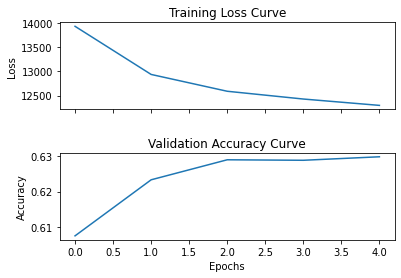

In [58]:
# Load data
zero_train_matrix, train_matrix, valid_data, test_data = load_data()

# Set model hyperparameters.
k = 50
lr = 0.01
num_epoch = 60
lamb = 0.001

model = AutoEncoder(train_matrix.shape[1], k)
model.to(device)

train(model, lr, lamb, train_matrix, zero_train_matrix, valid_data, num_epoch)

In [59]:
_, test_acc = evaluate(model, zero_train_matrix, test_data)
print(test_acc)

0.633079311318092


In [4]:
#torch.save(model.state_dict(), './model.pt')

model = AutoEncoder(train_matrix.shape[1], k)
model.load_state_dict(torch.load('./model.pt'))
model.eval()
model.to(device)

AutoEncoder(
  (g): Linear(in_features=1774, out_features=50, bias=True)
  (h): Linear(in_features=50, out_features=1774, bias=True)
)